In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import random
import os

#from Layers import num_params

In [12]:
del os.environ["PYTORCH_CUDA_ALLOC_CONF"]

KeyError: 'PYTORCH_CUDA_ALLOC_CONF'

In [2]:
torch.cuda.empty_cache()

In [3]:
def load_data(path, size, bs):
    tfms = fv.aug_transforms(size = size,
                             flip_vert=False, 
                             max_rotate=10, 
                             max_lighting=0.3, 
                             max_zoom=1.2,
                             max_warp=0.1)
    
    h,w = [int(2*t) for t in size]
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = fv.parent_label,
                        splitter  = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize((h,w)),
                        batch_tfms= tfms,
                     )
    return data.dataloaders(path, bs=bs)

#### Experimenta con diferentes tamaños!!

In [4]:
imagess = Path("/home/alumnos/.mi/concurso_ragui/CartoonImagenette")
files =fv.get_image_files(imagess);files
data = load_data(imagess,(128,192),20)

#### Cambia el siguiente modelo!!!

In [ ]:
def abc():
    



model = nn.Sequential(
    
    nn.Conv2d(3,16,kernel_size=6,stride=2,padding=2),
    nn.MaxPool2d(2),
    nn.BatchNorm2d(16),
    
    
    nn.Conv2d(16,32,kernel_size=4,stride=2,padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(32),
    
    
    nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1),
    nn.CELU(),
    nn.BatchNorm2d(64),
    
    nn.BatchNorm2d(64),
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(128),
    
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
    nn.CELU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
  
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
    nn.CELU(),
    nn.BatchNorm2d(512),
            
    nn.AdaptiveAvgPool2d(1),
    fv.Flatten(),
    nn.Linear(512,data.c)
)

In [5]:
"""
class SelfAttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttentionBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.attention = fv.SelfAttention(in_channels, 1)

    def forward(self, x):
        residual = x
        out = self.conv(x)
        out = self.attention(out)
        out += residual
        return out"""

class ResBlock(nn.Module):
    def __init__(self, residual):
        super().__init__()
        self.residual = residual

    def forward(self, x):
        return x + self.residual(x)
def residual(filters):
    bottleneck = (filters+1)//2
    residual = nn.Sequential(
        nn.Conv2d(filters, bottleneck, kernel_size=3,padding=1),
        nn.BatchNorm2d(bottleneck),
        nn.ReLU(),
        nn.Conv2d(bottleneck, filters, kernel_size=3,padding=1),
        nn.BatchNorm2d(filters)
    )
    nn.init.constant_(residual[-1].weight,0)
    # otra manera:
    with torch.no_grad():
        residual[-1].weight.zero_()
    return residual

In [6]:
del learn

NameError: name 'learn' is not defined

# Modelo Ganador

epoch,train_loss,valid_loss,accuracy,time
0,1.760700,1.747272,0.390000,02:24
1,1.580017,1.581375,0.412857,02:32
2,1.447660,1.469098,0.464286,02:31
3,1.359296,1.382304,0.498571,02:25
4,1.241935,1.330860,0.524286,02:29
5,1.167243,1.273775,0.521429,02:28
6,1.126301,1.389588,0.514286,02:31
7,1.025959,1.141767,0.580000,02:29
8,0.904598,1.059591,0.608571,02:27
9,0.795602,1.034965,0.615714,02:26


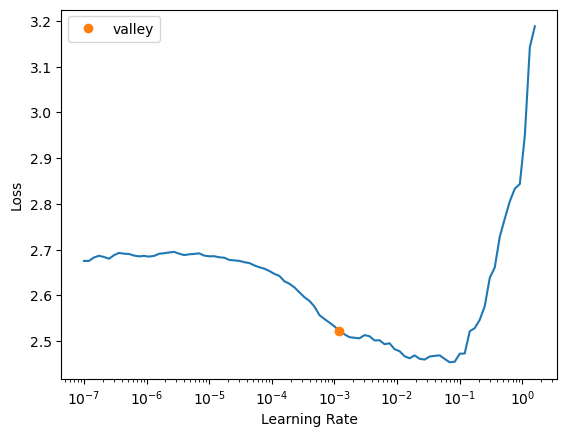

In [11]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layers = nn.Sequential(

            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),

            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.MaxPool2d(2),


            fv.SelfAttention(64),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            ResBlock(residual(128)),
            nn.LeakyReLU(),



            fv.SelfAttention(128),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),


            #fv.SelfAttention(256, 1),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x


model = Model()



learn = fv.Learner(data, model, metrics=fv.accuracy, opt_func=fv.ranger)
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.7, div_final=1000)

In [12]:
model.eval()

CustomModel(
  (conv_layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): CELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResBlock(
      (residual): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): CELU(alpha=1.0)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [13]:
learn.summary()

CustomModel (Input shape: 40 x 3 x 128 x 192)
Layer (type)         Output Shape         Param #    Trainable 
                     40 x 3 x 128 x 192  
BatchNorm2d                               6          True      
____________________________________________________________________________
                     40 x 32 x 128 x 192 
Conv2d                                    864        True      
CELU                                                           
____________________________________________________________________________
                     40 x 32 x 64 x 96   
MaxPool2d                                                      
____________________________________________________________________________
                     40 x 16 x 64 x 96   
Conv2d                                    4624       True      
BatchNorm2d                               32         True      
ReLU                                                           
___________________________________________

In [14]:
learn.save('/home/alumnos/.mi/modelos/modelito1')

Path('/home/alumnos/.mi/modelos/modelito1.pth')

In [15]:
interp = fv.ClassificationInterpretation.from_learner(learn);interp

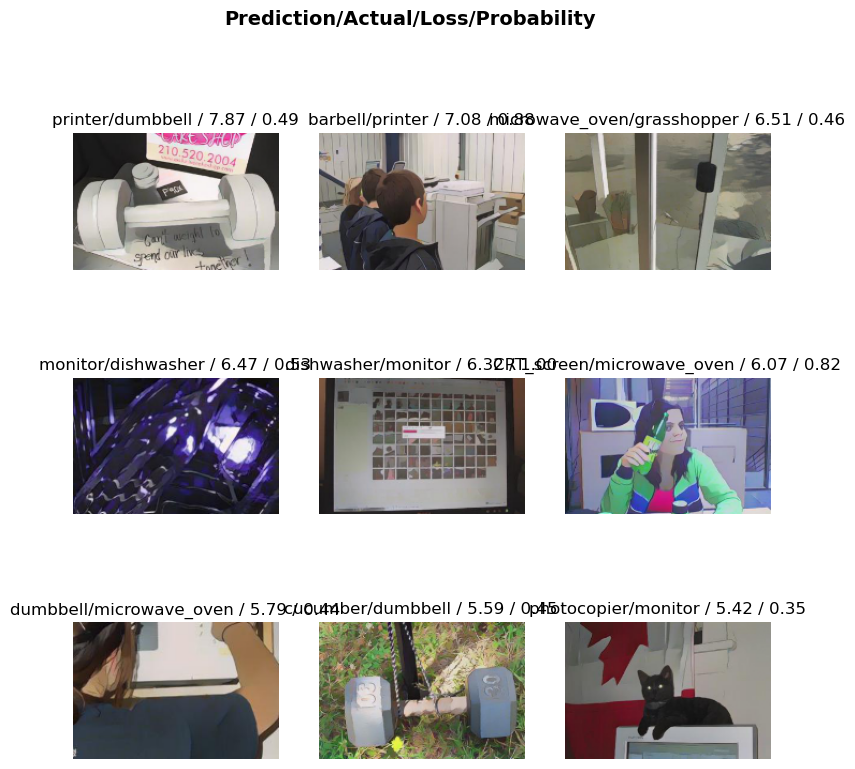

In [16]:
interp.plot_top_losses(9)

In [17]:
interp.most_confused(1)

[('CRT_screen', 'monitor', 23),
 ('barbell', 'dumbbell', 18),
 ('cucumber', 'zucchini', 17),
 ('zucchini', 'cucumber', 16),
 ('cricket', 'grasshopper', 15),
 ('dumbbell', 'barbell', 15),
 ('grasshopper', 'cricket', 13),
 ('monitor', 'CRT_screen', 13),
 ('dishwasher', 'microwave_oven', 11),
 ('bagel', 'cheeseburger', 10),
 ('printer', 'photocopier', 9),
 ('CRT_screen', 'microwave_oven', 8),
 ('photocopier', 'printer', 6),
 ('microwave_oven', 'CRT_screen', 5),
 ('CRT_screen', 'printer', 4),
 ('printer', 'monitor', 4),
 ('cheeseburger', 'bagel', 3),
 ('cricket', 'dishwasher', 3),
 ('dishwasher', 'monitor', 3),
 ('grasshopper', 'cucumber', 3),
 ('microwave_oven', 'monitor', 3),
 ('monitor', 'photocopier', 3),
 ('printer', 'CRT_screen', 3),
 ('printer', 'dishwasher', 3),
 ('CRT_screen', 'photocopier', 2),
 ('cucumber', 'monitor', 2),
 ('dishwasher', 'barbell', 2),
 ('dishwasher', 'photocopier', 2),
 ('dumbbell', 'dishwasher', 2),
 ('dumbbell', 'printer', 2),
 ('microwave_oven', 'barbell', 2

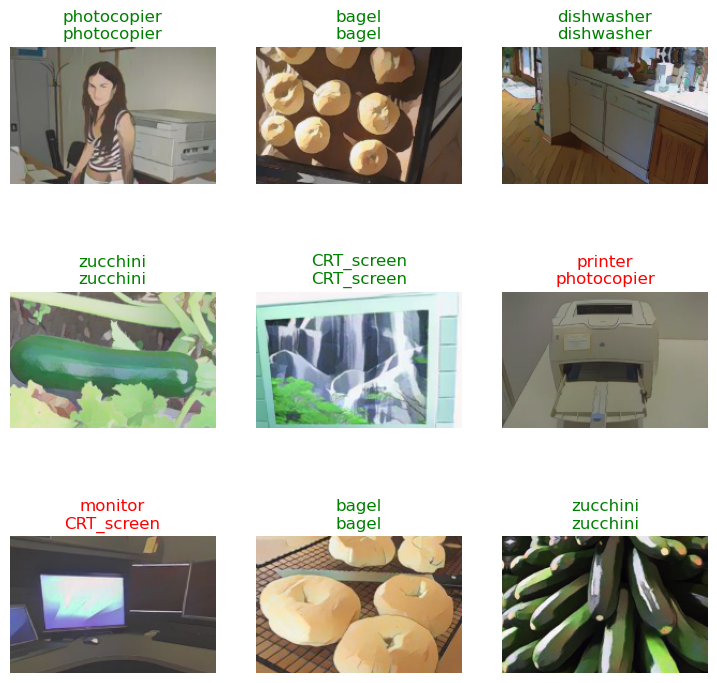

In [18]:
learn.show_results(ds_idx=3,dl=data.train,shuffle=True)

In [19]:
from math import prod
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [20]:

print(f"Num parameters: {num_params(model)/10**6:.2f}M")

Num parameters: 1.80M


# 2ndo experi

In [9]:
del learn

epoch,train_loss,valid_loss,accuracy,time
0,1.733439,1.634263,0.402857,03:07
1,1.603280,1.573802,0.418571,03:01
2,1.566442,1.468318,0.451429,02:53
3,1.568004,1.456331,0.455714,02:53
4,1.502210,1.534897,0.431429,02:53
5,1.448953,1.376020,0.492857,03:01
6,1.384669,1.389607,0.491429,03:01
7,1.283269,1.373676,0.481429,03:00
8,1.290220,1.231579,0.537143,03:01
9,1.202832,1.212693,0.540000,02:54


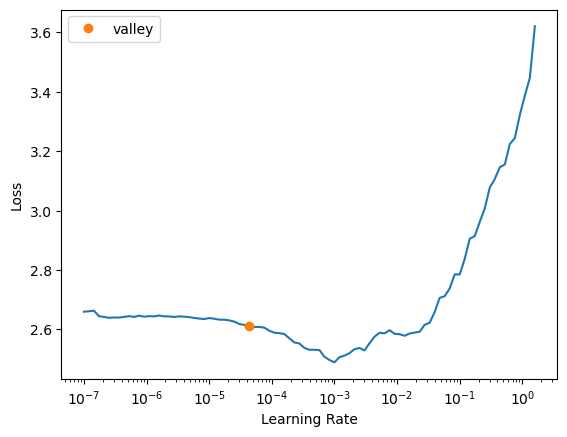

In [7]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()

        self.conv_layers = nn.Sequential(

            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),

            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.MaxPool2d(2),


            fv.SelfAttention(64),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            ResBlock(residual(128)),
            nn.LeakyReLU(),



            fv.SelfAttention(128),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 180, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(180),
            ResBlock(residual(180)),
            nn.MaxPool2d(2),
            
            
            
            nn.BatchNorm2d(180),

            nn.Conv2d(180, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(256),
            ResBlock(residual(256)),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),

            fv.SelfAttention(256),

            nn.Conv2d(256, 356, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(356),
            
            nn.Conv2d(356, 480, kernel_size=3, stride=1, padding=1),
            nn.CELU(),
            ResBlock(residual(480)),
            nn.BatchNorm2d(480),
            
            fv.SelfAttention(480),

            nn.Conv2d(480, 580, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(580),
            
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(580, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x


model = Model_1()



learn = fv.Learner(data, model, metrics=fv.accuracy, opt_func=fv.ranger)
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.7, div_final=1000)

epoch,train_loss,valid_loss,accuracy,time
0,1.828280,1.773525,0.408571,01:10
1,1.706228,1.736618,0.370000,01:11
2,1.643172,1.709774,0.414286,01:11
3,1.568190,1.651494,0.422857,01:12
4,1.515345,1.635858,0.395714,01:11
5,1.432080,1.422693,0.465714,01:10
6,1.367723,1.365350,0.487143,01:08
7,1.262719,1.269292,0.518571,01:08
8,1.140511,1.218562,0.537143,01:08
9,1.098264,1.172246,0.545714,01:08


AttributeError: 'NoneType' object has no attribute 'to_fp16'

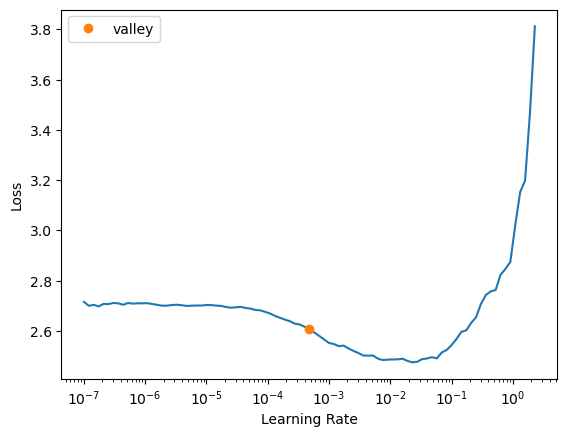

In [10]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.MaxPool2d(2),
        
            
            #fv.SelfAttention(64,1),
            nn.BatchNorm2d(64),
            #fv.PooledSelfAttention2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            
            
            
            #fv.SelfAttention(128, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            
            
            #fv.SelfAttention(256, 1),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x
model = Model_2()
cbs = [ fv.GradientClip(0.1)]# fv.MixedPrecision()
learn = fv.Learner(data, model,loss_func=nn.CrossEntropyLoss() ,metrics=fv.accuracy, opt_func=fv.ranger,cbs=cbs).to_fp16()
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.7, div_final=1000)

# 3er experi

In [12]:
del learn

epoch,train_loss,valid_loss,accuracy,time
0,2.205849,2.192562,0.278571,01:49
1,2.003575,1.991749,0.341429,01:49
2,1.818298,1.920778,0.320000,01:51
3,1.738180,2.066479,0.291429,01:52
4,1.689174,2.306372,0.257143,01:54
5,1.633091,1.878814,0.314286,01:53
6,1.568071,1.810685,0.354286,01:54
7,1.548764,1.568354,0.425714,01:54
8,1.510832,1.538924,0.435714,01:51
9,1.493677,1.532350,0.447143,01:51


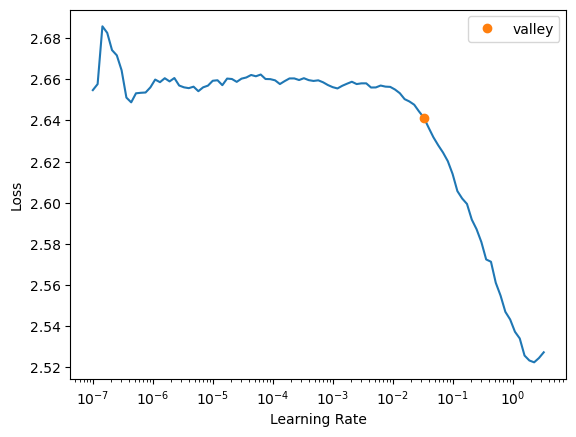

In [19]:
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.Tanh(),
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.Tanh(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.Sigmoid(),
            nn.MaxPool2d(2),
        
            
            #fv.SelfAttention(64,1),
            nn.BatchNorm2d(64),
            #fv.PooledSelfAttention2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.Tanh(),
            nn.Sigmoid(),
            ResBlock(residual(128)),
            nn.Sigmoid(),
            nn.LeakyReLU(),
            
            
            
            #fv.SelfAttention(128, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.ReLU(),
            ResBlock(residual(256)),
            nn.Tanh(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
            
            
            #fv.SelfAttention(256, 1),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            ResBlock(residual(512)),
            nn.Tanh(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x
model = Model_3()
cbs = [ fv.GradientClip(0.1)]# fv.MixedPrecision()
learn = fv.Learner(data, model,loss_func=nn.CrossEntropyLoss() ,metrics=fv.accuracy, opt_func=fv.ranger,cbs=cbs).to_fp16()
learn.fit_one_cycle(10, learn.lr_find(), div=7, pct_start=0.4, div_final=1000)

In [22]:
interp = fv.ClassificationInterpretation.from_learner(learn);interp
#interp.plot_confusion_matrix()

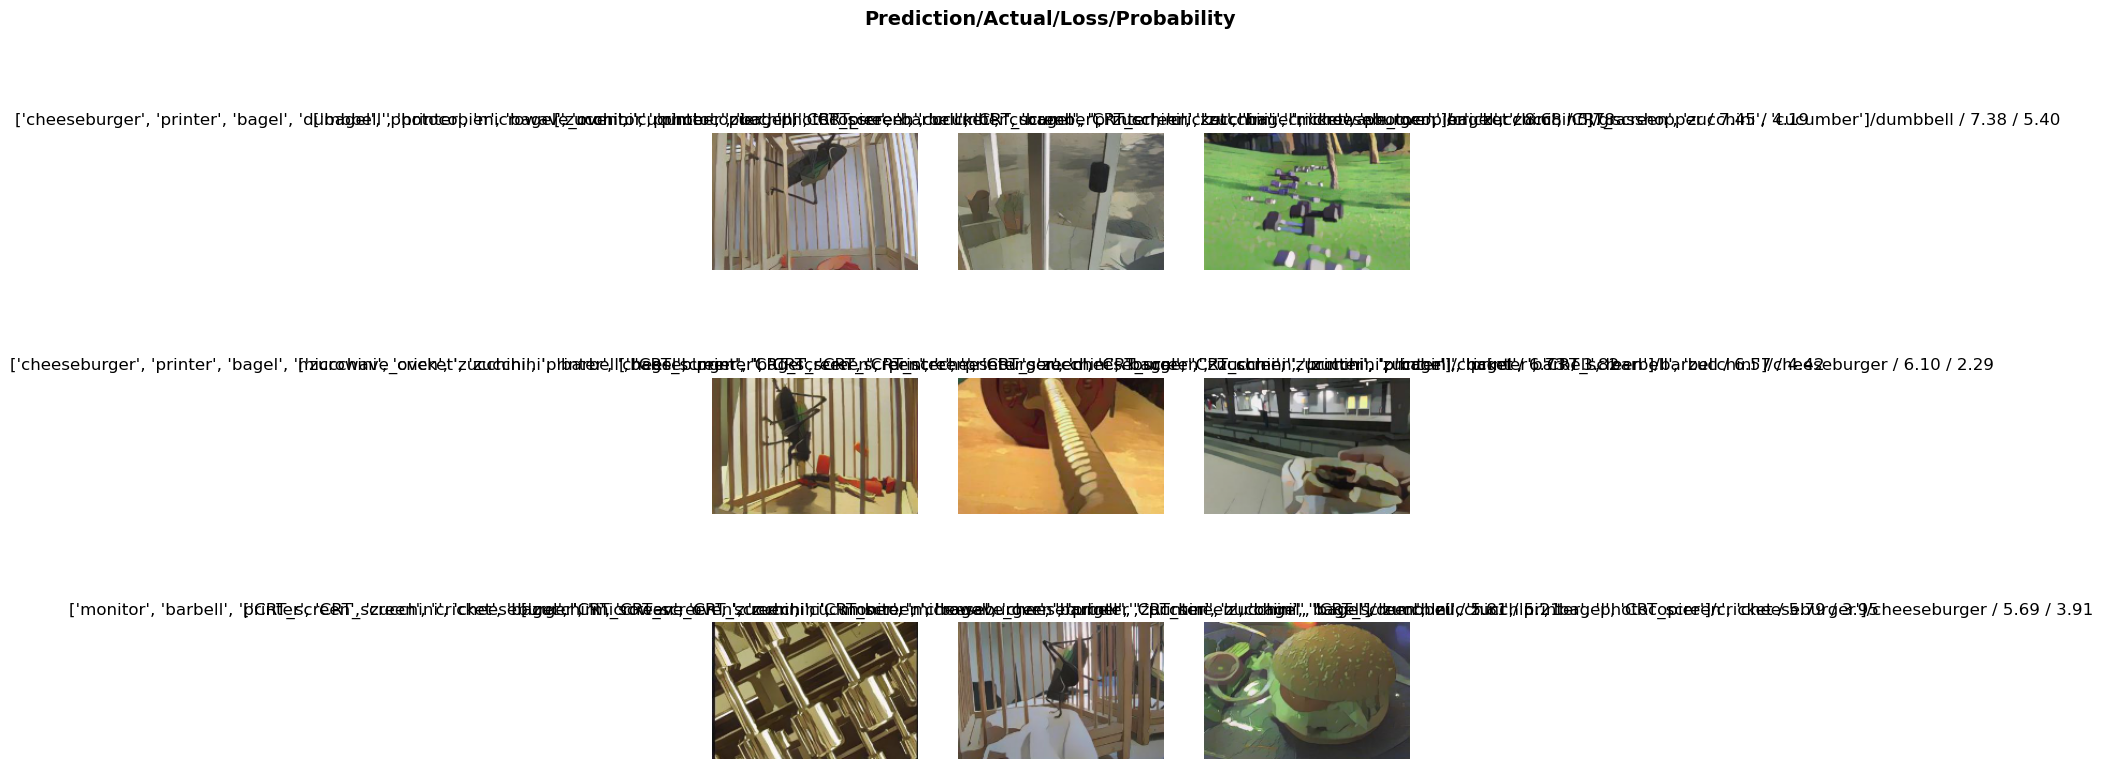

In [25]:
interp.plot_top_losses(9)
#interp.confusion_matrix()

In [31]:
interp.print_classification_report()

AssertionError: ==:
9800
700

In [8]:
class Model_35(nn.Module):
    def __init__(self):
        super(Model_35, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.MaxPool2d(2),
        
            
            #fv.SelfAttention(64,1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.LeakyReLU(),
            nn.BatchNorm2d(128)
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(128, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

# Crear una instancia del modelo
model = Model_35()


cbs = [ fv.GradientClip(0.1)]#fv.MixedPrecision()
learn = fv.Learner(data, model, metrics=fv.accuracy, opt_func=fv.ranger,cbs=cbs)
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.7, div_final=1000).to_fp16()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x196608 and 128x14)

# 4to experi

epoch,train_loss,valid_loss,accuracy,time
0,1.938061,1.904753,0.327143,02:30
1,1.780978,1.725986,0.381429,02:30
2,1.700229,1.706489,0.387143,02:31
3,1.686369,1.759078,0.385714,02:38
4,1.651384,1.823117,0.344286,02:34
5,1.654843,1.761120,0.370000,02:35
6,1.606996,1.632156,0.418571,02:33
7,1.603436,1.784236,0.354286,02:35
8,1.551380,1.613936,0.398571,02:45
9,1.505157,1.489228,0.432857,02:42


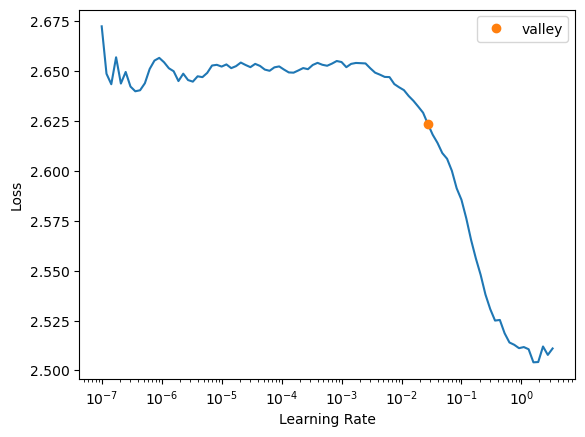

In [49]:



class Model_4(nn.Module):
    def __init__(self):
        super(Model_4, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(32)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(32)),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.MaxPool2d(2),
        
            
            #fv.SelfAttention(64,1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            #nn.MaxPool2d(2),
            nn.CELU(),
            ResBlock(residual(128)),
            nn.CELU(),
            nn.BatchNorm2d(128),
            #nn.MaxPool2d(2),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            ResBlock(residual(128)),
            
            
            
            
            #fv.SelfAttention(128, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.MaxPool2d(2),
            nn.CELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            ResBlock(residual(256)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(256)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(256)),
            
            
            #fv.SelfAttention(256, 1),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x


model = Model_4()





model = Model_4()
cbs = [ fv.GradientClip(0.16)]# fv.MixedPrecision()
learn = fv.Learner(data, model,metrics=fv.accuracy, opt_func=fv.Adam,cbs=cbs).to_fp16()
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.8, div_final=1200)

# 5TO EXPERI

epoch,train_loss,valid_loss,accuracy,time
0,2.152221,2.086266,0.308571,02:39
1,1.928164,1.882669,0.354286,02:34
2,1.807626,1.753256,0.368571,02:30
3,1.698912,1.933802,0.314286,02:30
4,1.648275,1.637927,0.387143,02:30
5,1.630523,1.632662,0.404286,02:39
6,1.593912,1.774264,0.381429,02:47
7,1.571927,1.539598,0.431429,02:47
8,1.518002,1.549682,0.431429,02:47
9,1.500834,1.508795,0.425714,02:47


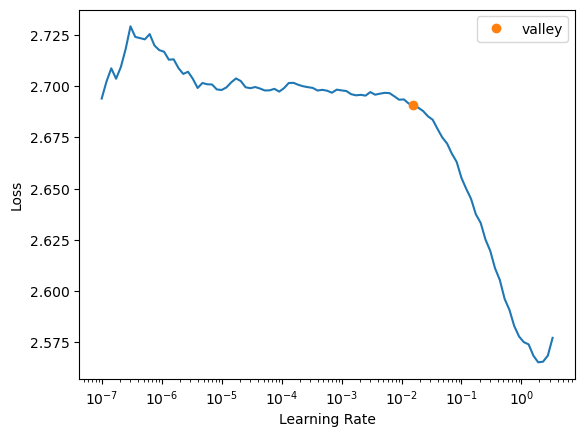

In [50]:

class Model_5(nn.Module):
    def __init__(self):
        super(Model_5, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(32)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(32)),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            ResBlock(residual(64)),
            nn.CELU(),
            nn.MaxPool2d(2),
        
            
            #fv.SelfAttention(64,1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            #nn.MaxPool2d(2),
            nn.CELU(),
            ResBlock(residual(128)),
            nn.CELU(),
            nn.BatchNorm2d(128),
            #nn.MaxPool2d(2),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            ResBlock(residual(128)),
            
            
            
            
            #fv.SelfAttention(128, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.MaxPool2d(2),
            nn.CELU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
            ResBlock(residual(256)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(256)),
            nn.LeakyReLU(),
            #nn.MaxPool2d(2),
            ResBlock(residual(256)),
            
            
            #fv.SelfAttention(256, 1),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(512),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

# Crear una instancia del modelo
model = Model_5()





model = CustomModel()
cbs = [ fv.GradientClip(0.1)]# fv.MixedPrecision()
learn = fv.Learner(data, model,metrics=fv.accuracy, opt_func=fv.ranger,cbs=cbs).to_fp16()
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.8, div_final=1200)

In [19]:
del learn

NameError: name 'learn' is not defined

# 6 to experi


In [25]:

class Model_6(nn.Module):
    def __init__(self):
        super(Model_6, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.CELU(),
            
            nn.Conv2d(3,8 , kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            #nn.MaxPool2d(2),
            nn.ELU(),
            nn.BatchNorm2d(8),
            nn.CELU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            nn.ELU(),
            ResBlock(residual(64)),
            nn.MaxPool2d(2),
            nn.CELU(),
        
            
            #fv.SelfAttention(64,1),
            nn.BatchNorm2d(64),
            nn.CELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            
            
            
            #fv.SelfAttention(128, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),
            
            
            #fv.SelfAttention(256, 1),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

# Crear una instancia del modelo
model = CustomModel()



learn = fv.Learner(data, model, metrics=fv.accuracy, opt_func=fv.ranger)
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.7, div_final=1000)

model = Model_6()
cbs = [ fv.GradientClip(0.1)]# fv.MixedPrecision()
learn = fv.Learner(data, model,loss_fun=nn.CrossEntropyLoss(),metrics=fv.accuracy, opt_func=fv.Adam,cbs=cbs).to_fp16()
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.8, div_final=1200)

RuntimeError: Given groups=1, weight of size [32, 16, 3, 3], expected input[64, 8, 128, 192] to have 16 channels, but got 8 channels instead

# 7timo experi

In [ ]:


class Model_7(nn.Module):
    def __init__(self):
        super(MOdel_7, self).__init__()

        self.conv_layers = nn.Sequential(
            
            nn.BatchNorm2d(3),
            nn.CELU(),
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.MaxPool2d(2),
            ResBlock(residual(32)),
            
            nn.BatchNorm2d(32),
            nn.CELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(64),
            nn.CELU(),
            ResBlock(residual(64)),
            nn.MaxPool2d(2),
            nn.CELU(),
        
            
            fv.SelfAttention(64),
            nn.BatchNorm2d(64),
            nn.CELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            ResBlock(residual(128)),
            nn.LeakyReLU(),
            
            
            
            fv.SelfAttention(128),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.LeakyReLU(),
            
            
            fv.SelfAttention(256),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),  # Ajuste del kernel_size y padding
            nn.CELU(),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(1),
        )

        self.linear_layers = nn.Sequential(
            fv.Flatten(),
            nn.Linear(512, 14)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.linear_layers(x)
        return x

# Crear una instancia del modelo
model = Model_7()



learn = fv.Learner(data, model, metrics=fv.accuracy, opt_func=fv.ranger)
learn.fit_one_cycle(10, learn.lr_find(), div=2, pct_start=0.7, div_final=1000)

#### Intenta usar Mixup o Cutmix! Intenta ranger!

In [ ]:
learn = fv.Learner(data,model,metrics=fv.accuracy).to_fp16()

In [ ]:
learn.lr_find()

### Experimenta con diferentes learning rates! Cambia div, div_final y pct_start!

In [ ]:
learn.fit_one_cycle(10)

## Ejemplos de funciones de ayuda

In [41]:
def conv2d(ni,no,k=3,s=1,pad="same",g=1,bias=True):
    """ni, no son num de canales de entrada y salida respectivamente"""
    if pad=="same": pad = (k-1)//2

    return nn.Conv2d(ni,no,kernel_size=k,stride=s,padding=pad,groups=g,bias=bias)

In [38]:
from fastai.vision.all import delegates

In [42]:
@delegates(conv2d)
def cab(ni, no, act_fn=nn.ReLU(), **kwargs):
    """cab se refiere a convolucion->activacion->batchnorm :)"""
    layers = []
    
    layers += [nn.Conv2d(ni, no, **kwargs)]
    layers += [act_fn]
    layers += [nn.BatchNorm2d(no)]
    
    return layers

In [43]:
def identity(x): return x

In [44]:
class ResBlock(nn.Module):
    def __init__(self, ni, no = None, stride=1):
        super().__init__()
        self.stride = stride
        if no is None: no = ni
            
        k = 3
        if stride == 2:
            k = 4
            
        use_pool = (ni != no) or (stride != 1)
        
        self.pool = nn.Sequential(*cab(ni,no,k=k,s=stride))
        self.residual = nn.Sequential(*cab(ni,ni//2,k=k,s=stride), # juega con esto!!
                                      *cab(ni//2,no//2), 
                                      *cab(no//2, no)
                                     )
        nn.init.zeros_(self.residual[-1].weight) # juega con esto!!
        
    def forward(self, x):
        return self.pool(x) + self.residual(x)